In [20]:
from collections import defaultdict, Counter
import string

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [4]:
def plot_word_number_histogram(text: str) -> None:
    """
    Function to display number of words
    :param text: input text
    """
    text.str.split().\
        map(lambda x: len(x)).\
        hist()


def plot_word_length_histogram(text: str) -> None:
    """
    Function for display word lenght
    :param text: input text
    """
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()


def plot_top_stopwords_barchart(text: str) -> list:
    """
    Function for clean and display stop words
    :param text: input text
    """
    stop=set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1
            
    top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10] 
    x,y = zip(*top)
    plt.bar(x,y)

    return corpus


def plot_top_non_stopwords_barchart(text: str) -> None:
    """
    Function for display non stop words
    :param text: input text
    """
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y, y=x)


def plot_top_ngrams_barchart(text: str, n=2) -> None:
    """
    Function for display top of ngrams
    :param text: input text
    :param n: default = 2, size of ngram
    """
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None) -> list:
        """
        Function for get top ngram
        :param corpus: list of words
        :param n: size of ngrams
        """
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)


def clear_string(text: str) -> str:
  """
  Function for cleaning text
  :param text: input text
  """
  text = ''.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stop])
  return text


def find_nearest_idx(query: str, embeddings: np.array, k: int) -> list:
    """ 
    нахождение индексов ближайшых текстов
    :param query: - query
    :param embedding: np.array vectors to find nearest with query
    :param k: number of nearest embeddings to find
    """
    query = clear_string(query)
    query_embedding = model.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, embeddings)[0]
    top_k_ind = torch.topk(cos_scores, K ).indices
    
    return [int(i) for i in top_k_ind]


def prepearing_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepearing dataset
    :param data: your dataset
    :return: pd.DataFrame
    """
    df_train = df.copy()
    df_train.is_duplicate = df_train.is_duplicate.astype('float32')
    df_train['name_1'] = df_train['name_1'].astype(str)
    df_train['name_2'] = df_train['name_2'].astype(str)
    df_train.dropna(inplace=True)
    return df_train

# Load Data

In [5]:
df = pd.read_csv(
    '/content/drive/MyDrive/Matching_string_project/Data/train.csv', index_col='pair_id')
df[:5]

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [6]:
print(df.shape)
df.info()

(497819, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [22]:
# making the stop words
stop = set(stopwords.words('english'))

# Text statistics analysis

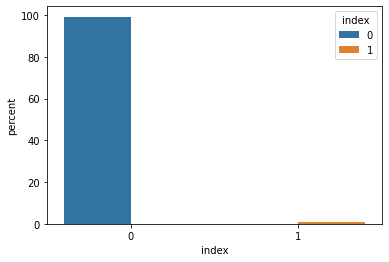

In [7]:
# check balance classes
target = df.is_duplicate.value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(x='index', y='percent', data=target, hue='index');

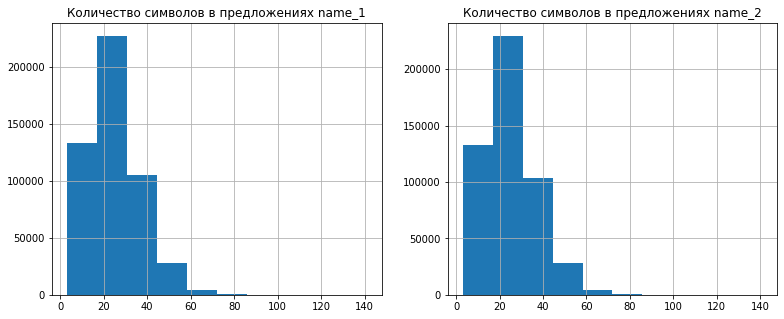

In [8]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  df[col].str.len().hist()
  plt.title(f'Количество символов в предложениях {col}')

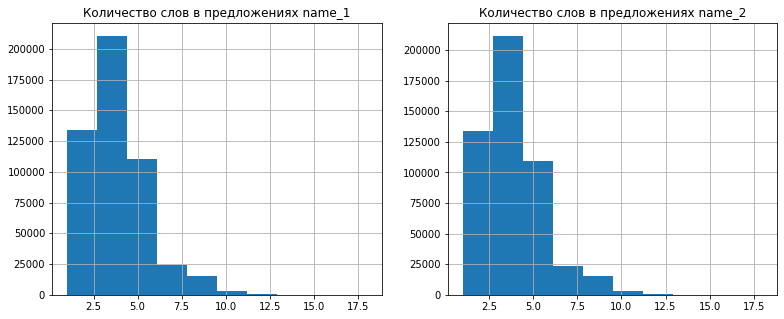

In [9]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_word_number_histogram(df[col])
  plt.title(f'Количество слов в предложениях {col}')

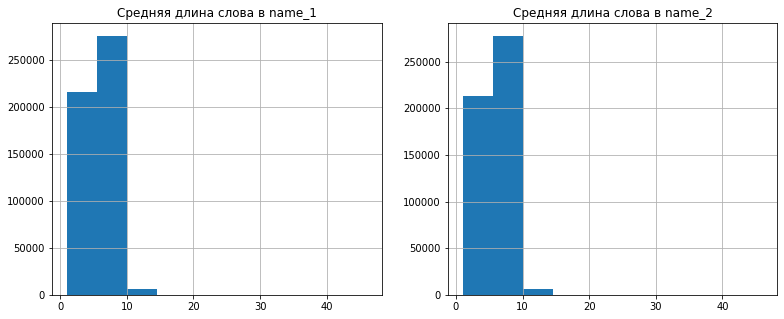

In [10]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_word_length_histogram(df[col])
  plt.title(f'Средняя длина слова в {col}')

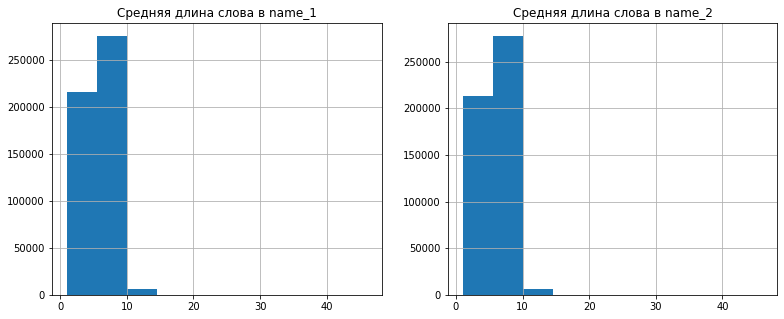

In [11]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_word_length_histogram(df[col])
  plt.title(f'Средняя длина слова в {col}')

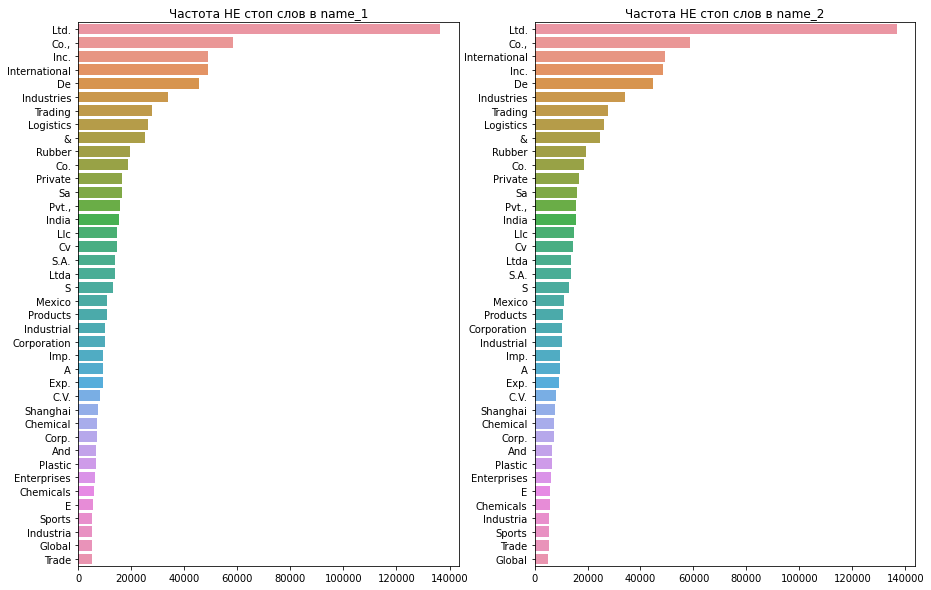

In [14]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_non_stopwords_barchart(df[col])
  plt.title(f'Частота НЕ стоп слов в {col}')

# Ngram Research

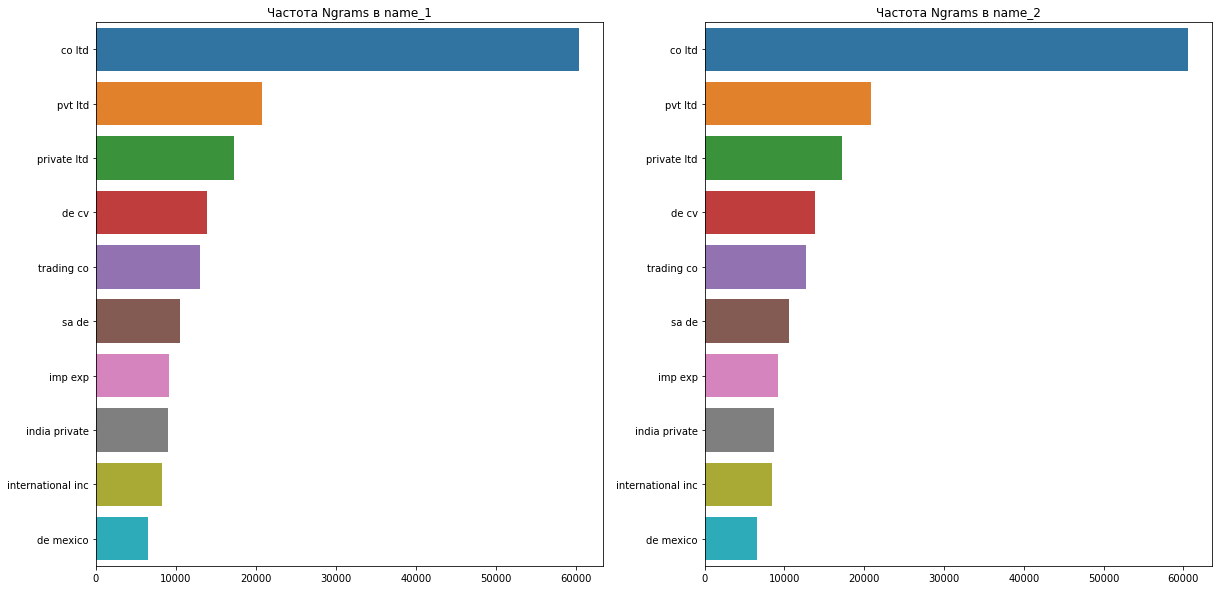

In [17]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_ngrams_barchart(df[col], 2)
  plt.title(f'Частота Ngrams в {col}')

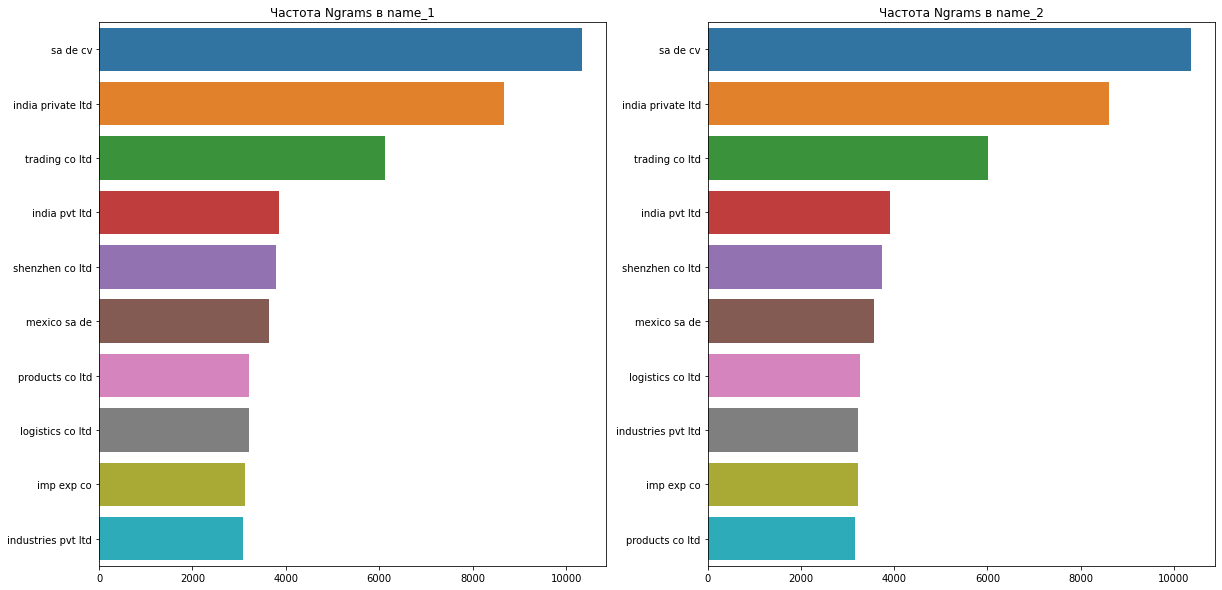

In [18]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_ngrams_barchart(df[col], 3)
  plt.title(f'Частота Ngrams в {col}')

# Clear data

In [23]:
df['name_1'] = df.apply(lambda x: clear_string(x['name_1']), axis=1)
df['name_2'] = df.apply(lambda x: clear_string(x['name_2']), axis=1)

# Save data

In [ ]:
df.to_csv('/content/drive/MyDrive/Matching_string_project/Data/cleaned.csv', index=False)